In [133]:
import numpy as np 
import pandas as pd
import datetime

import scipy.stats as ss
from scipy.stats import norm

import statsmodels.stats.stattools as stats
import statsmodels.formula.api as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels as stat

import linearmodels as lm

from workalendar.europe import NetherlandsWithSchoolHolidays as NL

import matplotlib.pyplot as plt 
import seaborn as sns

In [45]:
df = pd.read_csv('cleaned_data_reduced.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = (df.drop('Unnamed: 0', axis=1)
      .set_index('timestamp')
      .resample('D').sum())
df = df.loc['2015':'2020']

<AxesSubplot:xlabel='timestamp'>

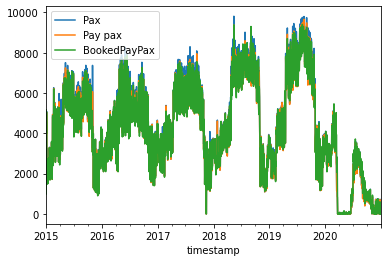

In [46]:
df.plot()

In [54]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Serie Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sma.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

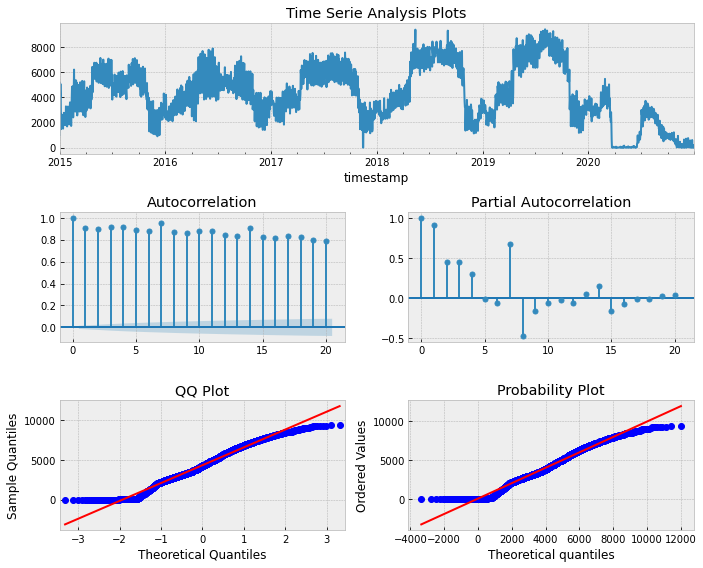

In [56]:
tsplot(df['BookedPayPax'], lags=20)

## Feature creation

In [62]:
calendar = NL(region='south', carnival_instead_of_spring=True)
all_holidays = []
for i in list(df.index.year.unique())[1:]:
    for j in calendar.holidays(i):
        all_holidays.append(j[0])
        
months ={'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
         'July':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

In [119]:
df = df.rename(columns={"Pay pax": "Pay_pax"})


df['Days_of_year'] = df.index.dayofyear
df['Holidays'] = [1 if i in all_holidays else 0 for i in df.index]
df['No_Show'] = df['BookedPayPax'] - df['Pay_pax']
df['Week'] = df.index.week
df['Months'] = df.index.month
df['RM_10'] = df['BookedPayPax'].rolling(10).mean()
df['SD_30'] = df['BookedPayPax'].rolling(30).std()



for i in list(months.keys()):
    df[i] = [1 if months[i]==df['Months'][j] else 0 for j in range(len(df)) ]

df['RM_10_L28'] = df['RM_10'].shift(28)
df['SD_30_L28'] = df['SD_30'].shift(28)
df['BPP_L28'] = df['BookedPayPax'].shift(28)
df['NS_L28'] = df['No_Show'].shift(28)
df = df.fillna(0)

# One data point is negative (to be retreated)
df[df['Pay_pax'] < 1] = 1
df

<ipython-input-119-376be1326a5b>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['Week'] = df.index.week


,Pax,Pay_pax,BookedPayPax,Holidays,No_Show,Week,Months,RM_10,RM_10_L28,BPP_L28,...,Aug,Sep,Oct,Nov,Dec,Days_of_year,SD_10,SD_10_L28,SD_30,SD_30_L28
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2023.0,2001.0,992.0,0,-1009.0,1,1,0.0,0.0,0.0,...,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000
2015-01-02,5163.0,5111.0,5169.0,0,58.0,1,1,0.0,0.0,0.0,...,0,0,0,0,0,2,0.000000,0.000000,0.000000,0.000000
2015-01-03,3995.0,3951.0,3989.0,0,38.0,1,1,0.0,0.0,0.0,...,0,0,0,0,0,3,0.000000,0.000000,0.000000,0.000000
2015-01-04,5095.0,5040.0,5069.0,0,29.0,1,1,0.0,0.0,0.0,...,0,0,0,0,0,4,0.000000,0.000000,0.000000,0.000000
2015-01-05,4271.0,4228.0,4104.0,0,-124.0,2,1,0.0,0.0,0.0,...,0,0,0,0,0,5,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,8.0,8.0,24.0,1,16.0,52,12,171.1,125.8,17.0,...,0,0,0,0,1,362,218.869113,230.062523,218.869113,230.062523
2020-12-28,12.0,11.0,11.0,1,0.0,53,12,115.1,97.2,7.0,...,0,0,0,0,1,363,218.743856,230.015494,218.743856,230.015494
2020-12-29,241.0,236.0,191.0,1,-45.0,53,12,132.3,116.6,196.0,...,0,0,0,0,1,364,217.658620,224.339275,217.658620,224.339275


### Change months into radials 

,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
timestamp,,,,,,,,,,,,
2015-01-01,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2015-01-02,0.998914,0.392526,0.020875,0.000150,1.463375e-07,1.929034e-11,3.441402e-16,9.976816e-12,8.635293e-08,0.000101,0.016035,0.344032
2015-01-03,0.995662,0.417914,0.023740,0.000183,1.898798e-07,2.673609e-11,5.094813e-16,7.151579e-12,6.611833e-08,0.000083,0.014009,0.321032
2015-01-04,0.990266,0.443978,0.026939,0.000221,2.458430e-07,3.697532e-11,7.526222e-16,5.115262e-12,5.051527e-08,0.000068,0.012211,0.298919
2015-01-05,0.982761,0.470644,0.030503,0.000268,3.176092e-07,5.102487e-11,1.109384e-15,3.650816e-12,3.851052e-08,0.000055,0.010622,0.277725
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.990266,0.298919,0.012211,0.000068,5.051527e-08,5.115262e-12,7.526222e-16,3.697532e-11,2.458430e-07,0.000221,0.026939,0.443978
2020-12-28,0.995662,0.321032,0.014009,0.000083,6.611833e-08,7.151579e-12,5.094813e-16,2.673609e-11,1.898798e-07,0.000183,0.023740,0.417914
2020-12-29,0.998914,0.344032,0.016035,0.000101,8.635293e-08,9.976816e-12,3.441402e-16,1.929034e-11,1.463375e-07,0.000150,0.020875,0.392526


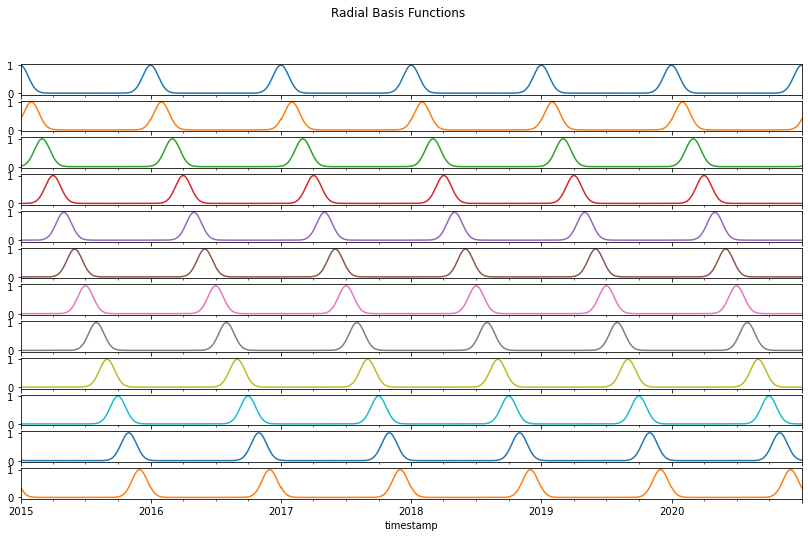

In [120]:
# radial dummies 
from sklego.preprocessing import RepeatingBasisFunction as RBF
rbf = RBF(n_periods=12,
             column="Days_of_year",
             input_range=(1,365),
             remainder="drop")

rbf.fit(df)
radials = pd.DataFrame(index=df.index,
               	data=rbf.transform(df))
radials.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);
radials.columns = list(months.keys())
radials

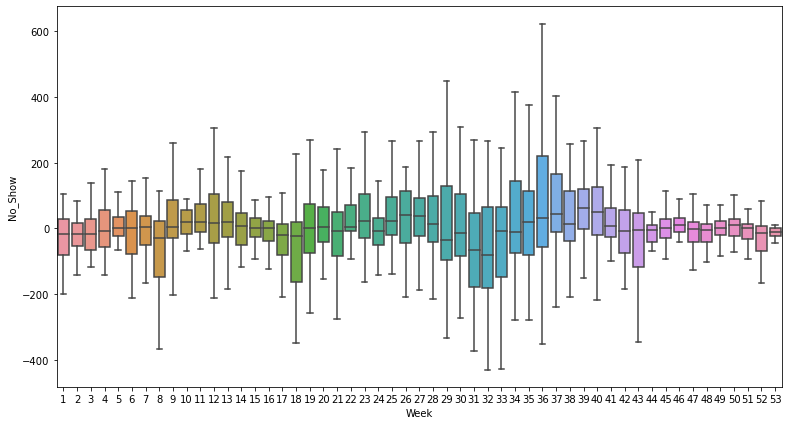

In [121]:
plt.figure(figsize=(13,7))
sns.boxplot(data=df, x="Week", y="No_Show", dodge=False, showfliers=False)
plt.show()

## Partition of data: training and val

In [127]:
#Partition the data into a train and test set
y_to_train = df['2016':'2019-06'] # dataset to train
y_to_val = df['2019-07':'2019-10'] # last X months for test  
predict_date = len(y_to_val)
predict_date

123

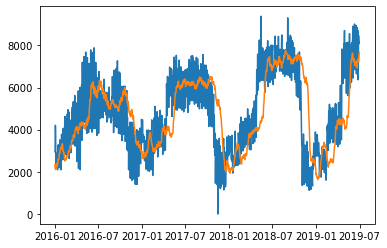

In [128]:
plt.plot(y_to_train[['BookedPayPax', 'RM_10_L28']])

## Testing the model 

In [129]:
my_formula = "Pay_pax ~ Holidays + RM_10_L28 + BPP_L28 + NS_L28 + SD_30_L28 + "+' + '.join(list(months.keys()))
my_formula

'Pay_pax ~ Holidays + RM_10_L28 + BPP_L28 + NS_L28 + SD_30_L28 + Jan + Feb + Mar + Apr + May + June + July + Aug + Sep + Oct + Nov + Dec'

                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     406.1
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:06:07   Log-Likelihood:                -10252.
No. Observations:                1277   AIC:                         2.054e+04
Df Residuals:                    1260   BIC:                         2.062e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2614.2908    165.323     15.813      0.0

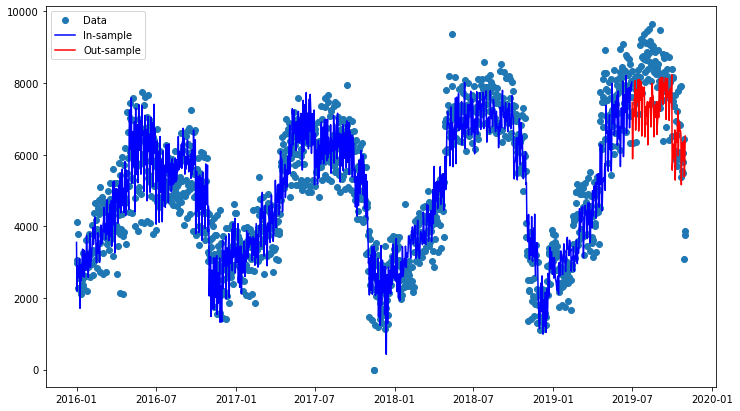

In [130]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
ypred = rslt.predict(y_to_train)
ypred_out = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df['Pay_pax']['2016':'2019-10'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out, "r-", label="Out-sample")
ax.legend(loc="best")

mse2 = ((ypred_out - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

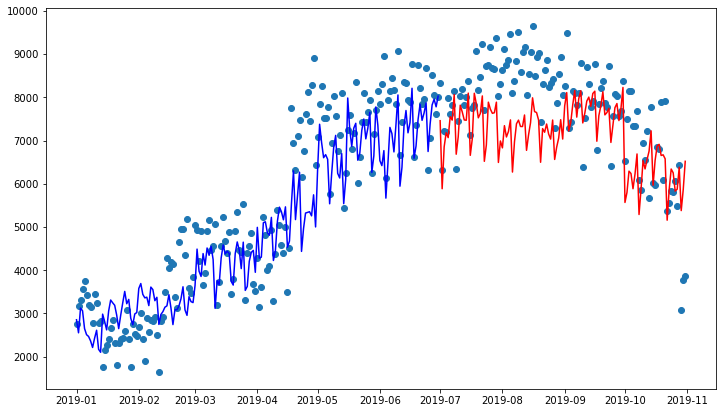

In [131]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df['Pay_pax']['2019':'2019-10'], "o", label="Data")
ax.plot(ypred['2019':], "b-", label="In-sample")
ax.plot(ypred_out, "r-", label="Out-sample")
plt.show()

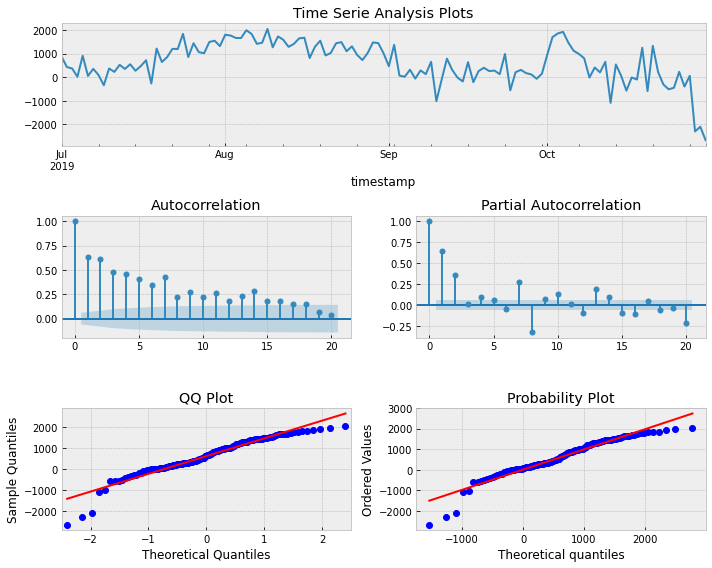

In [146]:
error = df['Pay_pax']['2019-07':'2019-10']- ypred_out
tsplot(error, lags=20)

## Garch Modelling 

In [148]:
from arch import arch_model

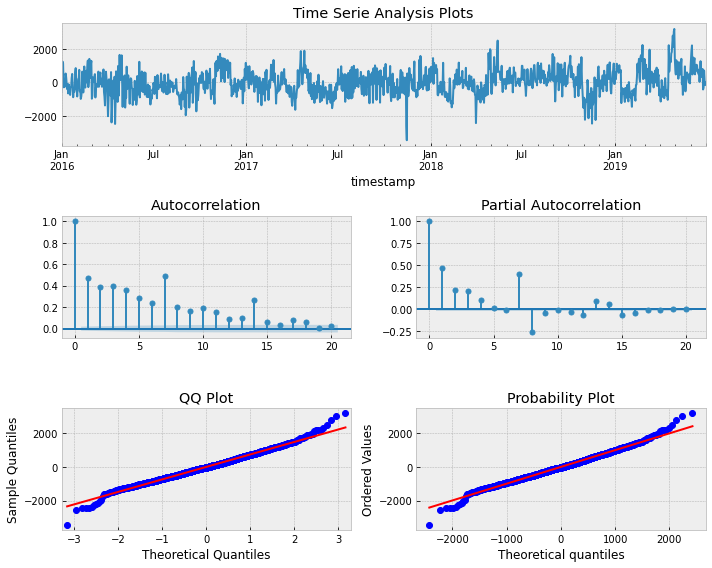

In [147]:
error = df['Pay_pax']['2016':'2019-06']- ypred
tsplot(error, lags=20)

In [149]:
am = arch_model(error, mean='AR', lags=7, vol='Garch', p=7, q=7)

In [151]:
my_model = am.fit(first_obs=pd.to_datetime('2016-01-01'),  last_obs=pd.to_datetime('2019-07-01'))
params = my_model.params
params

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.24e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 44782.96527158962
Iteration:      2,   Func. Count:     53,   Neg. LLF: 77914.94315636017
Iteration:      3,   Func. Count:     81,   Neg. LLF: 17588.475828598508
Iteration:      4,   Func. Count:    108,   Neg. LLF: 10315.178680510546
Iteration:      5,   Func. Count:    134,   Neg. LLF: 12007.231519918969
Iteration:      6,   Func. Count:    160,   Neg. LLF: 10987.268899572195
Iteration:      7,   Func. Count:    186,   Neg. LLF: 10497.330185293593
Iteration:      8,   Func. Count:    212,   Neg. LLF: 10767.150429287121
Iteration:      9,   Func. Count:    238,   Neg. LLF: 10185.91539871827
Iteration:     10,   Func. Count:    264,   Neg. LLF: 10309.073725029079
Iteration:     11,   Func. Count:    290,   Neg. LLF: 9932.743154612333
Iteration:     12,   Func. Count:    315,   Neg. LLF: 9878.340481983629
Iteration:     13,   Func. Count:    340,   Neg. LLF: 9852.007722488699
Iteration:     14,   Func. Count:    365,   Neg. LLF: 986

Const      -1.133343e+00
None[1]     2.772458e-01
None[2]     1.283954e-01
None[3]     1.374226e-01
None[4]     3.085706e-02
None[5]    -3.072363e-02
None[6]    -1.329708e-01
None[7]     4.029956e-01
omega       1.619961e+05
alpha[1]    7.092166e-02
alpha[2]    7.448685e-02
alpha[3]    2.771669e-02
alpha[4]    0.000000e+00
alpha[5]    5.100207e-02
alpha[6]    0.000000e+00
alpha[7]    1.131252e-01
beta[1]     1.841172e-02
beta[2]     7.098046e-13
beta[3]     1.386045e-12
beta[4]     5.404865e-02
beta[5]     8.946756e-13
beta[6]     1.368931e-12
beta[7]     8.401997e-02
Name: params, dtype: float64

In [157]:
forecasts = my_model.forecast(horizon=5, start=pd.to_datetime('2019-07-01'), method='simulation')
cond_mean = forecasts.mean['h.1']
cond_var = forecasts.variance['h.1']
epsilon = np.random.normal(0,1,size=len(cond_var))*np.sqrt(cond_var)
predictions = cond_mean + epsilon 

In [155]:
cond_mean

timestamp
2016-01-01   NaN
2016-01-02   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-01-05   NaN
              ..
2019-06-26   NaN
2019-06-27   NaN
2019-06-28   NaN
2019-06-29   NaN
2019-06-30   NaN
Name: h.1, Length: 1277, dtype: float64